In [1]:

# AirAware Smart Air Quality Prediction System
# Milestone 1: Data Preprocessing & EDA (Safe Version)
# Works with Kaggle "India Air Quality 2015-2024"
# Step 1: Upload Kaggle zip file (archive.zip)

from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [6]:
import zipfile, os

zip_path = list(uploaded.keys())[0]
extract_folder = "air_quality_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extracted files:", os.listdir(extract_folder))

Extracted files: ['station_day.csv', 'station_hour.csv', 'stations.csv', 'city_hour.csv', 'city_day.csv']


In [7]:
# Step 3: Load CSVs with auto-detect date columns
import pandas as pd

def load_csv_with_date(path):
    df = pd.read_csv(path)
    # Try to find a date/datetime column automatically
    for col in df.columns:
        if "date" in col.lower() or "time" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")
            return df, col
    return df, None

stations, _ = load_csv_with_date(f"{extract_folder}/stations.csv")
station_hour, station_hour_datecol = load_csv_with_date(f"{extract_folder}/station_hour.csv")
station_day, station_day_datecol = load_csv_with_date(f"{extract_folder}/station_day.csv")
city_hour, city_hour_datecol = load_csv_with_date(f"{extract_folder}/city_hour.csv")
city_day, city_day_datecol = load_csv_with_date(f"{extract_folder}/city_day.csv")

print(" Datasets loaded successfully")
print(" City-day date column:", city_day_datecol)
print(" Available Cities:", city_day["City"].unique()[:10])


 Datasets loaded successfully
 City-day date column: Datetime
 Available Cities: ['Delhi' 'Mumbai' 'Chennai' 'Kolkata' 'Bangalore']


In [19]:
# Step 3: Load CSVs with auto-detect date columns
# Step 3: Load CSVs with auto-detect date columns

def load_csv_with_date(path):
    """
    Reads a CSV and detects both date/time and station/city ID columns.
    Converts date/time column automatically.
    """
    df = pd.read_csv(path)
    date_col = None
    for col in df.columns:
        if "date" in col.lower() or "time" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")
            date_col = col
            break

    # Try to detect station id column if it exists
    station_col = None
    for col in df.columns:
        if "station" in col.lower() and "id" in col.lower():
            station_col = col
            break

    return df, date_col, station_col

# Reload with improved function
stations, _, _ = load_csv_with_date(f"{extract_folder}/stations.csv")
station_hour, station_hour_datecol, station_hour_idcol = load_csv_with_date(f"{extract_folder}/station_hour.csv")
station_day, station_day_datecol, station_day_idcol = load_csv_with_date(f"{extract_folder}/station_day.csv")
city_hour, city_hour_datecol, _ = load_csv_with_date(f"{extract_folder}/city_hour.csv")
city_day, city_day_datecol, _ = load_csv_with_date(f"{extract_folder}/city_day.csv")

print("Datasets loaded")
# Print column names for each dataset
print("station_day columns:", station_day.columns.tolist())
print("station_hour columns:", station_hour.columns.tolist())
print("city_day columns:", city_day.columns.tolist())
print("city_hour columns:", city_hour.columns.tolist())
print("stations columns:", stations.columns.tolist())



Datasets loaded
station_day columns: ['City', 'Datetime', 'Station', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
station_hour columns: ['City', 'Datetime', 'Station', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
city_day columns: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
city_hour columns: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
stations columns: ['City', 'Station']


In [20]:
# STEP 3: Dropdown menus to choose dataset, city, and station
# - dataset_dropdown: choose one of the four main datasets
# - city_dropdown: pick a city (only used if you select city_day / city_hour)
# - station_dropdown: pick a station (only used if you select station_day / station_hour)

import ipywidgets as widgets
from IPython.display import display
# Dataset selector
dataset_dropdown = widgets.Dropdown(
    options=["city_day", "city_hour", "station_day", "station_hour"],
    description="Dataset:",
)
display(dataset_dropdown)
# City selector (for city_* datasets)
city_dropdown = widgets.Dropdown(
    options=sorted(city_day["City"].dropna().unique()),
    description="City:",
)
display(city_dropdown)
# Station selector (for station_* datasets)
station_dropdown = widgets.Dropdown(
    options=sorted(station_day["Station"].dropna().unique()),
    description="Station:",
)
display(station_dropdown)


Dropdown(description='Dataset:', options=('city_day', 'city_hour', 'station_day', 'station_hour'), value='city…

Dropdown(description='City:', options=('Bangalore', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai'), value='Bangalore…

Dropdown(description='Station:', options=('Station_B1', 'Station_B2', 'Station_C1', 'Station_C2', 'Station_D1'…

In [23]:
# STEP 5: Function to filter dataset based on your selection
# - Sets "Datetime" as index
# - Filters by city or station
# - Keeps only numeric pollutant columns
# - Resamples daily or hourly and fills missing values with interpolation

def get_dataset(dataset, city=None, station=None):
    if dataset == "city_day":
        df = city_day[city_day["City"]==city].copy()
        df = df.set_index("Datetime").sort_index()
    elif dataset == "city_hour":
        df = city_hour[city_hour["City"]==city].copy()
        df = df.set_index("Datetime").sort_index()
    elif dataset == "station_day":
        df = station_day[station_day["Station"]==station].copy()
        df = df.set_index("Datetime").sort_index()
    elif dataset == "station_hour":
        df = station_hour[station_hour["Station"]==station].copy()
        df = df.set_index("Datetime").sort_index()
    else:
        raise ValueError("Invalid dataset selected")

    # Keep only numeric pollutant columns (ignore City/Station text)
    df_numeric = df.select_dtypes(include="number")

    # Resample: daily datasets → D, hourly datasets → H
    if "day" in dataset:
        df_numeric = df_numeric.resample("D").mean().interpolate()
    else:
        df_numeric = df_numeric.resample("h").mean().interpolate()

    return df_numeric

# Example: use current dropdown selections
selected_dataset = dataset_dropdown.value
selected_city = city_dropdown.value
selected_station = station_dropdown.value

df_sel = get_dataset(selected_dataset, city=selected_city, station=selected_station)
print(f"Data ready from {selected_dataset}:", df_sel.shape)
df_sel.head()


Data ready from city_day: (3653, 13)


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Datetime,,,,,,,,,,,,,
2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7
2015-01-02,22.5,317.5,163.0,62.4,130.9,46.7,0.00,59.7,49.8,16.31,7.77,5.83,243.3
2015-01-03,269.3,69.9,195.5,107.3,232.0,36.4,7.44,12.8,119.4,16.97,19.69,8.60,148.5
2015-01-04,56.1,295.7,121.0,146.1,53.7,39.8,6.47,59.1,109.1,9.40,6.11,9.56,423.3
2015-01-05,263.8,321.1,21.4,40.5,48.0,0.6,7.30,56.2,14.2,2.78,13.53,9.62,119.5


from matplotlib import pyplot as plt
_df_36['PM2.5'].plot(kind='hist', bins=20, title='PM2.5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['PM10'].plot(kind='hist', bins=20, title='PM10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_38['NO'].plot(kind='hist', bins=20, title='NO')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_39['NO2'].plot(kind='hist', bins=20, title='NO2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_40.plot(kind='scatter', x='PM2.5', y='PM10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41.plot(kind='scatter', x='PM10', y='NO', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_42.plot(kind='scatter', x='NO', y='NO2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_43.plot(kind='scatter', x='NO2', y='NOx', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_44['PM2.5'].plot(kind='line', figsize=(8, 4), title='PM2.5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_45['PM10'].plot(kind='line', figsize=(8, 4), title='PM10')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_46['NO'].plot(kind='line', figsize=(8, 4), title='NO')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_47['NO2'].plot(kind='line', figsize=(8, 4), title='NO2')
plt.gca().spines[['top', 'right']].set_visible(False)

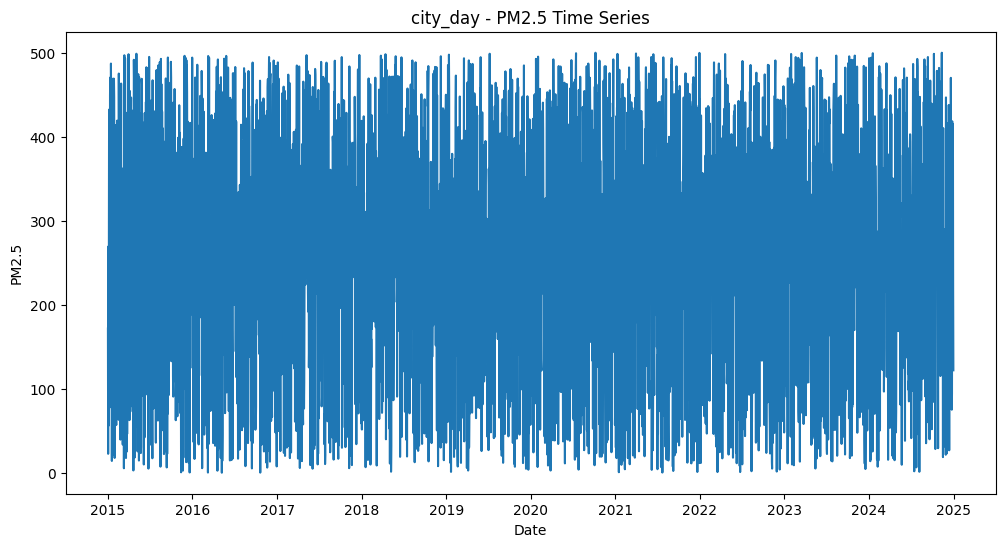

In [24]:
# STEP 6: Plot PM2.5 over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(x=df_sel.index, y=df_sel["PM2.5"])
plt.title(f"{selected_dataset} - PM2.5 Time Series")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.show()


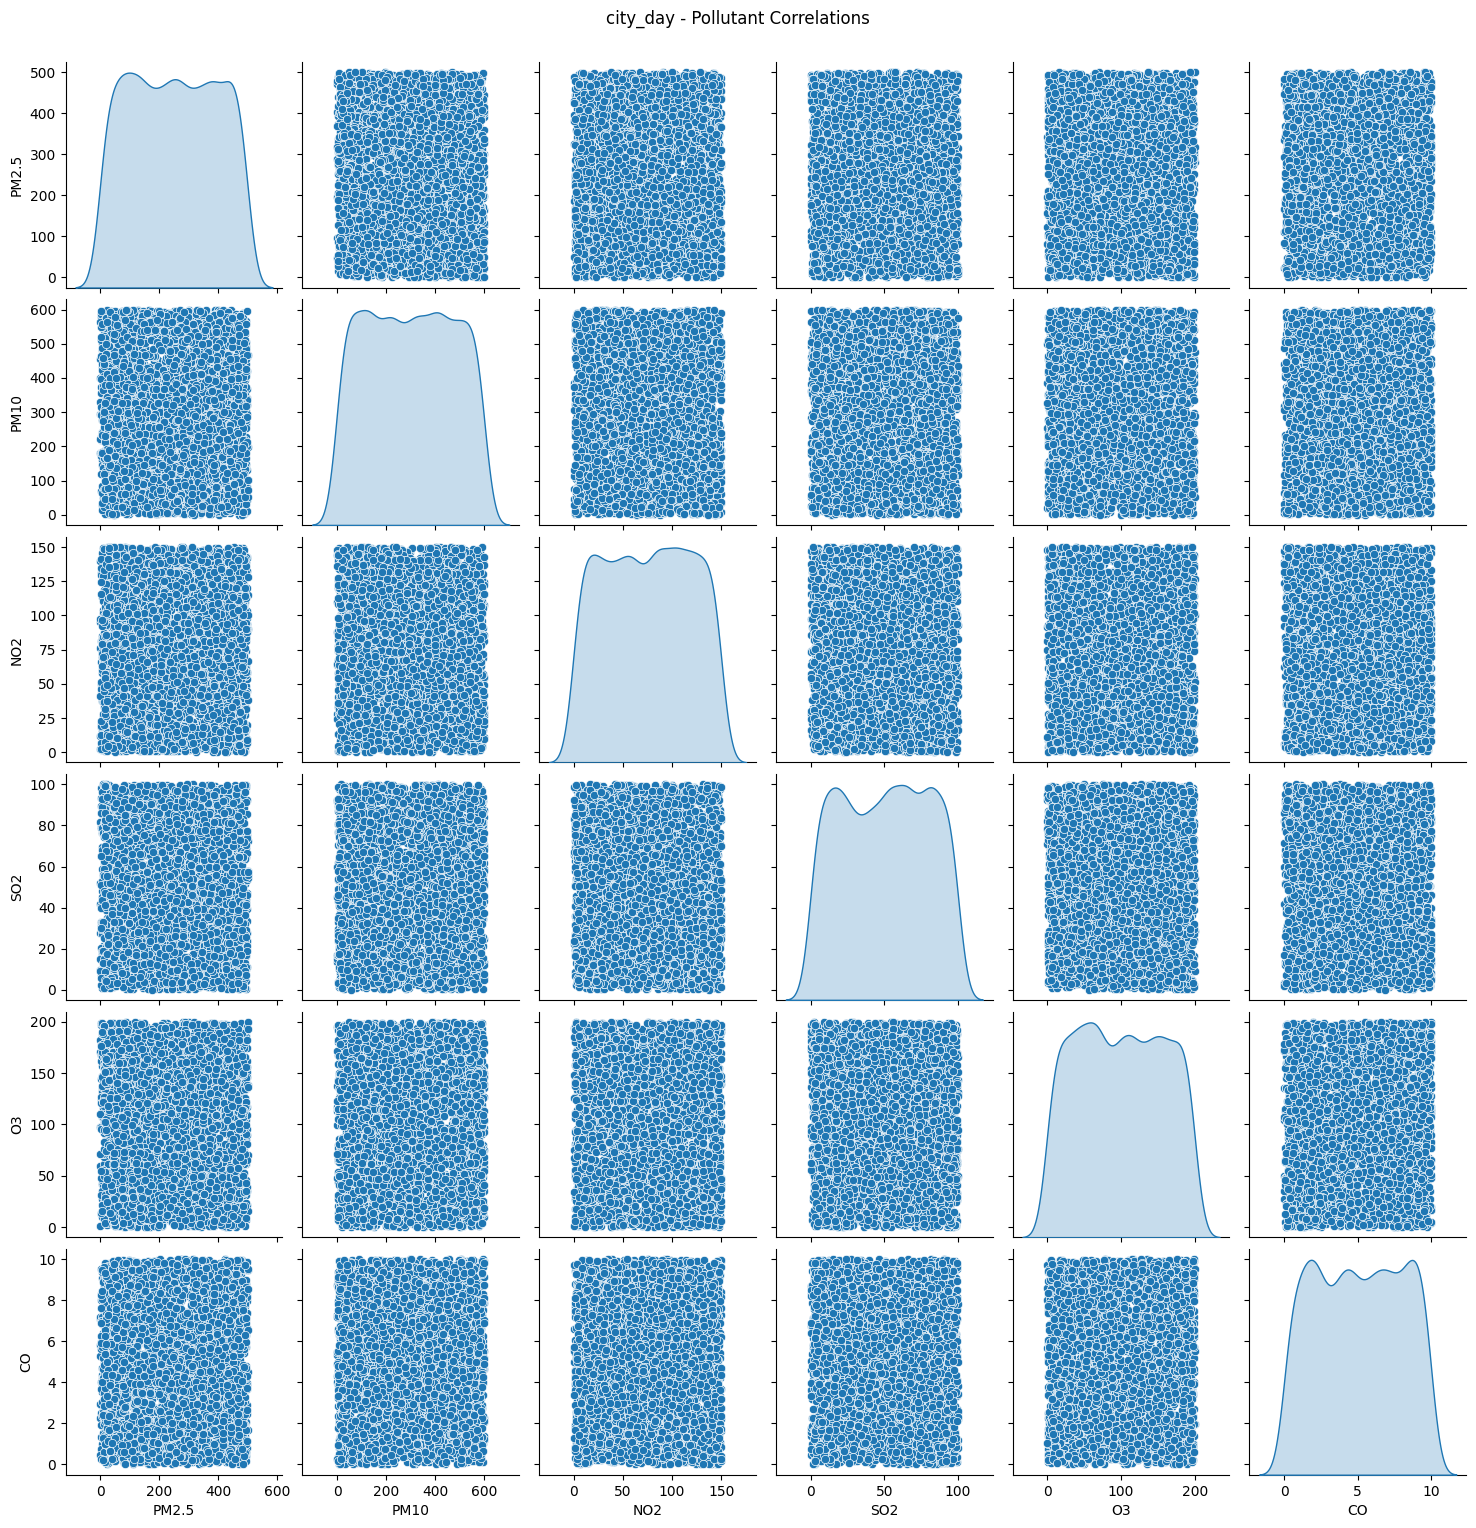

In [25]:
# STEP 7: Scatterplots to see correlations between pollutants
num_cols = [c for c in ["PM2.5","PM10","NO2","SO2","O3","CO"] if c in df_sel.columns]

sns.pairplot(df_sel[num_cols].dropna(), diag_kind="kde")
plt.suptitle(f"{selected_dataset} - Pollutant Correlations", y=1.02)
plt.show()


In [26]:
# STEP 8: Statistical summary (mean, median, max, std, count)
summary = df_sel[num_cols].describe().T
print(f" Statistical Summary for {selected_dataset}")
print(summary[["mean","50%","max","std","count"]])


 Statistical Summary for city_day
             mean     50%    max         std   count
PM2.5  248.546838  248.80  499.9  144.749067  3653.0
PM10   296.769888  298.70  599.9  174.226049  3653.0
NO2     75.026225   76.20  150.0   43.559083  3653.0
SO2     50.283192   51.60  100.0   29.061423  3653.0
O3      99.202792   98.90  200.0   57.853254  3653.0
CO       5.059650    5.03   10.0    2.892137  3653.0


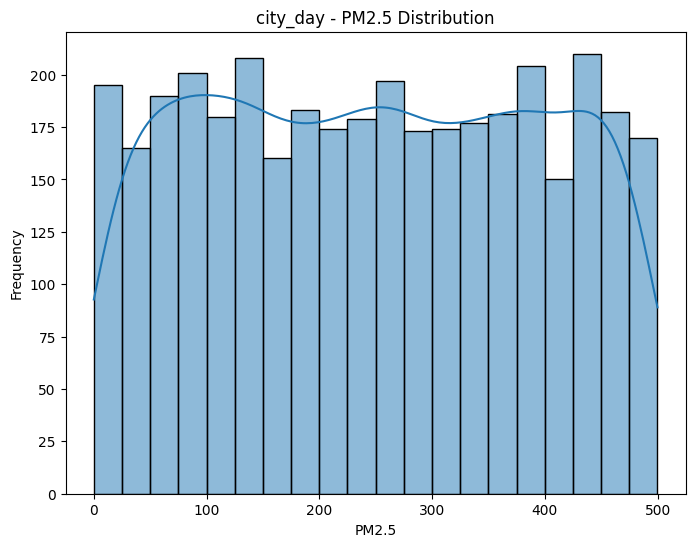

In [27]:
# STEP 8: Histogram of PM2.5 values
if "PM2.5" in df_sel.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(df_sel["PM2.5"].dropna(), bins=20, kde=True)
    plt.title(f"{selected_dataset} - PM2.5 Distribution")
    plt.xlabel("PM2.5")
    plt.ylabel("Frequency")
    plt.show()


In [28]:
# STEP 10: Data quality metrics
# - Completeness = % of rows with valid pollutant values
# - Validity = % of non-missing values across all pollutants

total_rows = len(df_sel)
valid_rows = df_sel[num_cols].dropna().shape[0]

completeness = round((valid_rows / total_rows) * 100, 2)
validity = round(100 - (df_sel.isna().mean().mean() * 100), 2)

print("Data Quality Check")
print(f"Completeness: {completeness}%")
print(f"Validity: {validity}%")


Data Quality Check
Completeness: 100.0%
Validity: 100.0%
